In [1]:
import pickle
import os
import glob
import numpy as np
import pandas as pd
from scipy import sparse

In [2]:
gene2go_matrix_validated = sparse.load_npz('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/validated_gene2go_matrix.npz')
with open('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/validated_go2gene_dict.pkl','rb') as f :
    go_genelist = pickle.load(f)

In [3]:
def edit_revigo(file) :
    df = pd.read_csv(file,sep ='\t')
    tmp = list(set(df['Representative']))
    reps = [x for x in tmp if x == x]
    for i in range(df.shape[0]) :
        name = df['Name'][i]
        if name in reps :
            df['Representative'][i] = name
    filename = file.split('.')[0]
    df.to_csv(filename + '_fixed.txt',sep=',',index=False)

#pass
import glob
files = glob.glob('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/revigo/*.txt')
for f in files :
    edit_revigo(f)

In [4]:
def function_module_geneset(df,go2gene) :
    modules = np.unique([x for x in df['Representative'].values if x == x])
    modules_dict = dict()
    for m in modules :
        idx = np.where(df['Representative'] == m)
        go_list = df['TermID'].loc[idx].values
        for go in go_list :
            if m not in modules_dict.keys() :
                modules_dict[m] = go2gene[go]
            else :
                modules_dict[m] = np.concatenate([modules_dict[m],go2gene[go]])
        modules_dict[m] = list(set(modules_dict[m]))
    return modules_dict

In [ ]:
files = glob.glob('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/Revigo_gsea/*fixed.txt')
path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/Revigo_gsea/'
for f in files :
    name = f.split('/')[-1][:-10]
    print(name)
    df = pd.read_csv(f)
    module_d = function_module_geneset(df,go_genelist)
    with open(path + name + '.pkl','wb') as f :
        pickle.dump(module_d,f)
    f.close()

### functional module comparison

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import re

def Jaccar_score(lista1, lista2):    
    inter = len(list(set(lista1) & set(lista2)))
    union = len(list(set(lista1) | set(lista2)))
    return inter/union

def go_term_gene_similarity_comparison(go_list,go2gene_dict) :
    jac_matrix = np.zeros((len(go_list),len(go_list)))
    cb = combinations(np.arange(len(go_list)),2)
    for idx1,idx2 in cb :
        go1 = go_list[idx1]
        go2 = go_list[idx2]
        jac_matrix[idx1,idx2] = Jaccar_score(go2gene_dict[go1],go2gene_dict[go2])
        
    jac_df = pd.DataFrame(jac_matrix,index=go_list,columns=go_list)
        
    return jac_df

def cut_index_name(string,sep = ' ',replace = '\n') :
    idx = [m.start(0) for m in re.finditer(sep,string)]
    for n,i in enumerate(idx) :
        if n % 4 == 0 and n > 0:
            string = string[:i] + replace + string[i + 1:]
    return string

def module_comparison_revigo(path1,path2) :
    #load functional module pickle file (dict format)
    with open(path1,'rb') as f :
        module1 = pickle.load(f)
        f.close()

    with open(path2,'rb') as f :
        module2 = pickle.load(f)
        f.close()

    module1_list = list(module1.keys())
    module2_list = list(module2.keys())
    jac_matrix = np.zeros((len(module1_list),len(module2_list)))

    for idx1,k1 in enumerate(module1_list) :
        for idx2,k2 in enumerate(module2_list) :
            a = module1[k1]
            b = module2[k2]
            score = Jaccar_score(a,b)
            jac_matrix[idx1,idx2] = score

    module1_list = [cut_index_name(x) for x in module1_list]
    module2_list = [cut_index_name(x) for x in module2_list]
    
    jac_df = pd.DataFrame(jac_matrix,index=module1_list,columns=module2_list)
    
    return jac_df

def plot_jaccard_matrix(df,title,output) :
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    # plot heatmap
    g = sns.clustermap(df,cmap=cmap, vmin=0, vmax=1,  cbar_kws={"shrink": .8})
    g.ax_cbar.set_position((0.05, .4, .03, .4))
    g.ax_row_dendrogram.set_visible(False)
    g.fig.suptitle(title) 
    plt.savefig(output,dpi = 300,bbox_inches = 'tight')


### gene similarity between GO term

In [40]:
final_go = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/final_tsea.txt',sep='\t',index_col=0)
final_go_list = list(final_go.index)

with open('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/validated_go2gene_dict.pkl','rb') as f :
    go2gene_dict = pickle.load(f)
f.close()

In [30]:
vote_tsea = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/pass_vote_tsea_go.txt',sep='\t',index_col=0)
fold_change_tsea = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/fold_change_tsea.txt',sep='\t',index_col=0)

In [47]:
jac_m = go_term_gene_similarity_comparison(final_go_list,go2gene_dict)
plot_jaccard_matrix(jac_m,'gene jaccrad index between candidate GO term','/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/gene_sim_between_goterm.png')

In [ ]:
from itertools import combinations

files = glob.glob('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/Revigo_gsea/*BP*.pkl')
com = combinations(files,2)
fig_output_path = '/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/'

for file1,file2 in com :
    jac_m = module_comparison_revigo(file1,file2)
    name1 = file1.split('/')[-1].split('.')[0].split('_')[-1]
    name2 = file2.split('/')[-1].split('.')[0].split('_')[-1] 
    title = 'Revigo_BP_' + name1 + '_vs_' + name2
    fig_name = title + '.png'
    plot_jaccard_matrix(jac_m,title.replace('_',' '),fig_output_path + fig_name)

### predict HBV by functional module geneset

In [3]:
test_file = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/lihc_protein_coding_gene_std_exp_profile.txt'
exp_profile = pd.read_csv(test_file,sep='\t',index_col = 0)

hallmark = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt",sep = '\t',header=None)
hallmark_gene = hallmark.iloc[:,0].values

metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/sample_info/sample_info_df.txt',sep='\t',index_col=0)
idx = np.where(metadata['Label'] == 'Tumor',True,False)
metadata = metadata.loc[idx,:]
metadata.index = metadata['Sample'].values

In [4]:
final_go = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/final_tsea.txt',sep='\t',index_col=0)
final_go_list = list(final_go.index)

with open('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/validated_go2gene_dict.pkl','rb') as f :
    go2gene_dict = pickle.load(f)
f.close()

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

hbv = metadata.loc[exp_profile.columns,'HBV'].values
y = np.where(hbv == 'Positive',1,0)
### parameter for model
metrics = ['accuracy','recall','precision','hallmark_ratio']
xgb_model = XGBClassifier()

    
metric_matrix = np.zeros((len(final_go_list),len(metrics)+3))

for idx,m in enumerate(final_go_list) :
    genes = list(set(go2gene_dict[m]).intersection(exp_profile.index))
    x = exp_profile.loc[genes,:].T.to_numpy()
    for midx,metric in enumerate(metrics[:3]) :
        scores = cross_val_score(xgb_model, x, y,cv=5,scoring=metric)
        metric_matrix[idx,midx] = np.mean(scores)
        metric_matrix[idx,midx+4] = np.std(scores)
    num_hallmark = len(set(genes).intersection(hallmark_gene))
    metric_matrix[idx,3] = num_hallmark / len(genes)

metrics = metrics + ['accuracy_std','recall_std','precision_std']
metric_df = pd.DataFrame(metric_matrix,index = final_go_list,columns=metrics)
metric_df = metric_df.sort_values(by='accuracy',ascending=False)

In [22]:
import json 

graph_d = dict()
graph_path = '/home/bruce1996/data/GO/networkx/'
go_field = ['biological_process','cellular_component','molecular_function']
for field in go_field :
    file = graph_path + field + '.go'
    with open(file , 'rb') as f:  # notice the r instead of w
        graph_d[field] = pickle.load(f)
        f.close()

with open("/home/bruce1996/data/GO/go2namespace.json",'rb') as f :
    go2namespace = json.load(f)
    f.close()

In [29]:
plot_df = metric_df.copy()
go_name = []
for go in metric_df.index :
    namespace = go2namespace[go]
    name = graph_d[namespace].nodes[go]['name']
    name = go + ':' + name
    go_name.append(name)
plot_df['GO_description'] = go_name

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric_df(metric_df,title,output,figsize = (12,5)) :

    df = metric_df.iloc[:,:4]
    df['GO_description'] = metric_df['GO_description']
    plot_df = df.melt(id_vars='GO_description')
    plot_df.columns = ['GO_description','Metric','Value']
    
    plt.figure(figsize=figsize)
    sns.barplot(data=plot_df,x='GO_description',y='Value',hue='Metric',palette='Set2')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.ylabel('Metric')
    plt.savefig(output,dpi=300,bbox_inches='tight',format = 'svg')

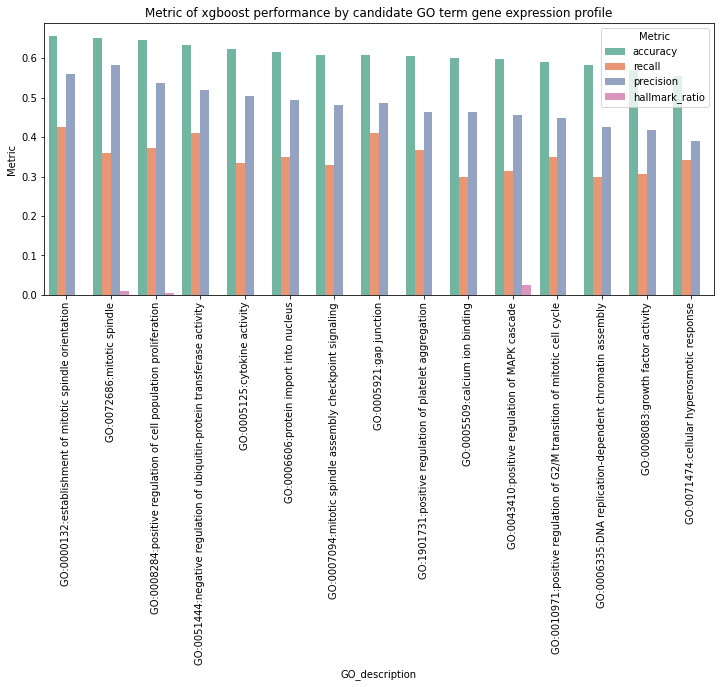

In [41]:
path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/functional_module_evaluation/xgb_performance/'
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/xgb_performance_evaluation/'
title = 'Metric of xgboost performance by candidate GO term gene expression profile'
plot_metric_df(plot_df,title,output_path + 'final_candidate_go_metric.svg')